In [52]:
import pandas as pd
import spacy
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

import string
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
news = pd.read_csv('../Data/corona_news_scraped_on_19th_march.csv')
news.head()

,datetime,text
0,"17:58 (IST), Mar 19",Those asked to undergo quarantine should follo...
1,"17:57 (IST), Mar 19",We have succeeded in keeping coronavirus at co...
2,"17:55 (IST), Mar 19",201 Indians evacuated from Iran yesterday: Avi...
3,"17:55 (IST), Mar 19",Vistara to temporarily suspend international o...
4,"17:52 (IST), Mar 19","Lav Agarwal, Joint Secretary, Health Ministry:..."


In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
datetime    285 non-null object
text        285 non-null object
dtypes: object(2)
memory usage: 4.5+ KB


In [4]:
nlp = spacy.load('en_core_web_sm')

### Cleaning up for NLP tasks

In [5]:
# Remove HTML Tags
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free_text = soup.get_text()
    return html_free_text

# Remove Punctuations
def punctuation_remover(text):
    punctuation_free_text = " ".join([word for word in text if word \
                                    not in string.punctuation])
    return punctuation_free_text


# Stop Word Removal
cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
def stop_words_remover(text):
    text = text.lower().split()
    words = [word for word in text if \
             word not in cached_stop_words]
    return words

# Lemmatization
def lemmatize_words(text):
    words = nlp(str(text))
    return [word.lemma_ for word in words if word.lemma_ != '-PRON-']    
        

In [6]:
news['cleaned_text'] = news.text.apply(remove_html)
news['cleaned_text'] = news.cleaned_text.apply(stop_words_remover)
news['cleaned_text'] = news.cleaned_text.apply(lemmatize_words)
news['cleaned_text'] = news.cleaned_text.apply(punctuation_remover)
news['cleaned_text'] = news.cleaned_text.apply(word_tokenize)

In [7]:
news.head()

,datetime,text,cleaned_text
0,"17:58 (IST), Mar 19",Those asked to undergo quarantine should follo...,"[ask, undergo, quarantine, follow, rule, else,..."
1,"17:57 (IST), Mar 19",We have succeeded in keeping coronavirus at co...,"[succeed, keep, coronavirus, containment, leve..."
2,"17:55 (IST), Mar 19",201 Indians evacuated from Iran yesterday: Avi...,"[201, indian, evacuate, iran, yesterday, aviat..."
3,"17:55 (IST), Mar 19",Vistara to temporarily suspend international o...,"[vistara, temporarily, suspend, international,..."
4,"17:52 (IST), Mar 19","Lav Agarwal, Joint Secretary, Health Ministry:...","[lav, agarwal, joint, secretary, health, minis..."


### Topic Modelling

#### Unigram

In [8]:
# Create Corpora
dictionary = corpora.Dictionary(news.cleaned_text)

# Create document term Matrix (Bag of words)
document_bow = [dictionary.doc2bow(doc) for doc in news.cleaned_text ]

In [9]:
lda_model = LdaModel(corpus=document_bow ,num_topics=10, id2word=dictionary,passes = 100)

In [10]:
for i, topic in lda_model.print_topics(-1):
    print('Topic: {} Words :{}'.format(i,topic))

Topic: 0 Words :0.014*"coronavirus" + 0.012*"say" + 0.010*"minister" + 0.010*"pm" + 0.010*"take" + 0.009*"cut" + 0.007*"modi" + 0.007*"cm" + 0.007*"delhi" + 0.007*"home"
Topic: 1 Words :0.031*"case" + 0.030*"coronavirus" + 0.022*"report" + 0.018*"say" + 0.015*"first" + 0.014*"positive" + 0.013*"new" + 0.012*"test" + 0.012*"#" + 0.010*"train"
Topic: 2 Words :0.021*"march" + 0.018*"mumbai" + 0.016*"till" + 0.013*"suspend" + 0.012*"service" + 0.010*"board" + 0.009*"31" + 0.009*"'s" + 0.008*"today" + 0.008*"school"
Topic: 3 Words :0.024*"coronavirus" + 0.014*"say" + 0.011*"#" + 0.011*"state" + 0.010*"uddhav" + 0.009*"work" + 0.008*"covid-19" + 0.008*"cm" + 0.008*"fight" + 0.008*"pandemic"
Topic: 4 Words :0.014*"quarantine" + 0.014*"coronavirus" + 0.010*"day" + 0.009*"passenger" + 0.009*"people" + 0.008*"suspect" + 0.007*"travel" + 0.007*"tuesday" + 0.007*"uddhav" + 0.006*"thackeray"
Topic: 5 Words :0.022*"coronavirus" + 0.010*"say" + 0.008*"covid-19" + 0.008*"country" + 0.007*"wednesday" +

In [11]:
lda_display = pyLDAvis.gensim.prepare(lda_model,document_bow,dictionary,sort_topics=False)
pyLDAvis.display(lda_display)

### Sentiment Analysis

In [12]:
def test_sentiment_analyzer(use_textblob = True ,use_vader=False):
    for sentence in news.text[50:60]:
        print(sentence,'\n')
        analyzed_sentence = TextBlob(sentence) if use_textblob==True  \
                             else SentimentIntensityAnalyzer().polarity_scores(sentence)
        print(analyzed_sentence.sentiment if use_textblob==True else analyzed_sentence,'\n')

In [13]:
test_sentiment_analyzer(use_textblob=True)

MEA briefs media on coronavirus 

Sentiment(polarity=0.0, subjectivity=0.0) 

One more person has been tested positive in Tamil Nadu, says health minister C Vijaya Baskar 

Sentiment(polarity=0.36363636363636365, subjectivity=0.5227272727272727) 

Chhattisgarh CM Bhupesh Baghel: Section 144 has been imposed in Raipur and all other municipal corporation areas in the state to prohibit large gatherings 

Sentiment(polarity=0.04464285714285714, subjectivity=0.4017857142857143) 

Work from home, staggered working hours for central govt employeesThe Central government on Thursday allowed 50 per cent of its employees to work from home and the remaining to attend office every day besides implementing different time slots for working hours in its effort to further check the spread of the coronavirus disease. In the first week, heads of departments have been asked to include only staff who reside in close proximity to their office or use own transport to travel to office. It suggested that three

In [14]:
test_sentiment_analyzer(use_textblob=False,use_vader=True)

MEA briefs media on coronavirus 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

One more person has been tested positive in Tamil Nadu, says health minister C Vijaya Baskar 

{'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.5574} 

Chhattisgarh CM Bhupesh Baghel: Section 144 has been imposed in Raipur and all other municipal corporation areas in the state to prohibit large gatherings 

{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'compound': -0.0772} 

Work from home, staggered working hours for central govt employeesThe Central government on Thursday allowed 50 per cent of its employees to work from home and the remaining to attend office every day besides implementing different time slots for working hours in its effort to further check the spread of the coronavirus disease. In the first week, heads of departments have been asked to include only staff who reside in close proximity to their office or use own transport to travel to office. It suggested that three groups of 

#### _We will use vader sentiment analyzer as results are somewhat better_

In [15]:
def sentiment_calculator(text):
    analyzer =  SentimentIntensityAnalyzer().polarity_scores(text)
    return analyzer['compound']

news['sentiment_score'] = news.text.apply(sentiment_calculator)

In [16]:
label = ( lambda x : 'positive' if x > 0.05 else 'negative' )

news['sentiment'] = news.sentiment_score.apply(label)

### TF-IDF

In [24]:
tfidf = TfidfModel(document_bow)
corpus_tfidf = tfidf[document_bow]

In [32]:
d ={}
for doc in corpus_tfidf:
    for id, value in doc:
        word = dictionary.get(id)
        d[word] = value

In [49]:
tfidf_word_with_score = pd.DataFrame.from_dict( d ,orient = 'index',columns = ['score'])
tfidf_word_with_score.sort_values(by = 'score',ascending =False,inplace=True)
tfidf_word_with_score.head(20)

,score
tracking,0.993745
teaching,0.754652
dm,0.703124
fear,0.699354
soldier,0.688727
name,0.677794
pr,0.658389
jawan,0.651677
bed,0.639902
bengaluru,0.601477


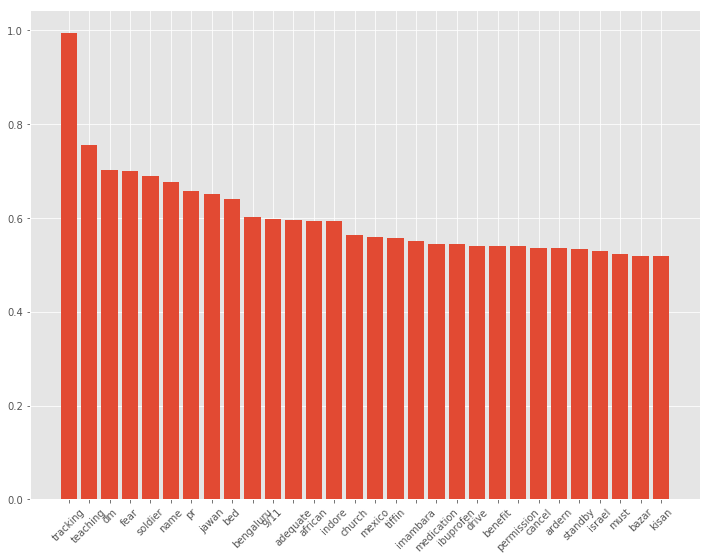

In [64]:
plt.style.use('ggplot')
plt.figure(figsize=(12,9))
plt.xticks(rotation='45')
plt.bar(tfidf_word_with_score.index[:30],tfidf_word_with_score.score[:30])
plt.show()

In [29]:
lda_model_tfidf = LdaModel(corpus=corpus_tfidf ,num_topics=10,id2word=dictionary,passes =150)

In [30]:
for i, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Words :{}'.format(i,topic))

Topic: 0 Words :0.004*"joint" + 0.004*"secretary" + 0.003*"ministry" + 0.003*"work" + 0.003*"50" + 0.003*"tracking" + 0.003*"transmission" + 0.003*"office" + 0.003*"agarwal" + 0.003*"lav"
Topic: 1 Words :0.004*"aircraft" + 0.003*"teaching" + 0.002*"economy" + 0.002*"mea" + 0.002*"vc" + 0.002*"thing" + 0.002*"recover" + 0.002*"reach" + 0.002*"137" + 0.002*"andhra"
Topic: 2 Words :0.003*"moscow" + 0.003*"covid19" + 0.002*"social" + 0.002*"rumour" + 0.002*"tibetan" + 0.002*"locate" + 0.002*"vidyalya" + 0.002*"tehran" + 0.002*"sangathan" + 0.002*"kv"
Topic: 3 Words :0.003*"ani" + 0.002*"now" + 0.002*"bed" + 0.002*"contain" + 0.002*"mea" + 0.002*"iran" + 0.002*"cut" + 0.002*"ongoing" + 0.002*"chalking" + 0.002*"actively"
Topic: 4 Words :0.010*"case" + 0.008*"report" + 0.008*"new" + 0.007*"say" + 0.007*"positive" + 0.006*"coronavirus" + 0.006*"test" + 0.006*"#" + 0.006*"first" + 0.006*"death"
Topic: 5 Words :0.005*"uddhav" + 0.004*"emergency" + 0.004*"singapore" + 0.004*"private" + 0.004*"me

In [65]:
for index, score in sorted(lda_model_tfidf[document_bow[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.4991118013858795	 
Topic: 0.010*"case" + 0.008*"report" + 0.008*"new" + 0.007*"say" + 0.007*"positive" + 0.006*"coronavirus" + 0.006*"test" + 0.006*"#" + 0.006*"first" + 0.006*"death"

Score: 0.4281404912471771	 
Topic: 0.004*"10" + 0.003*"child" + 0.003*"concessional" + 0.003*"cancel" + 0.003*"union" + 0.003*"remain" + 0.003*"ticket" + 0.003*"advise" + 0.003*"icse" + 0.003*"year"


In [108]:
topics_list = []
for index in news.index:
    topic_dic = {}
    
    for i, score in sorted(lda_model_tfidf[document_bow[index]], key=lambda tup: -1*tup[1]):
        topic_dic['i'] = i
        topic_dic['score'] = score
        continue
    
    topics_list.append(topic_dic.get('i'))

In [110]:
news['topic'] = topics_list

In [111]:
news.head()

,datetime,text,cleaned_text,sentiment_score,sentiment,topic
0,"17:58 (IST), Mar 19",Those asked to undergo quarantine should follo...,"[ask, undergo, quarantine, follow, rule, else,...",0.0000,negative,4
1,"17:57 (IST), Mar 19",We have succeeded in keeping coronavirus at co...,"[succeed, keep, coronavirus, containment, leve...",0.4215,positive,4
2,"17:55 (IST), Mar 19",201 Indians evacuated from Iran yesterday: Avi...,"[201, indian, evacuate, iran, yesterday, aviat...",0.0000,negative,8
3,"17:55 (IST), Mar 19",Vistara to temporarily suspend international o...,"[vistara, temporarily, suspend, international,...",-0.3182,negative,3
4,"17:52 (IST), Mar 19","Lav Agarwal, Joint Secretary, Health Ministry:...","[lav, agarwal, joint, secretary, health, minis...",-0.2960,negative,8


In [112]:
news.sentiment.value_counts()

negative    194
positive     91
Name: sentiment, dtype: int64

In [113]:
news.topic.value_counts()

4    111
5     31
6     30
9     29
0     25
8     14
3     13
2     11
1     11
7     10
Name: topic, dtype: int64